<a href="https://colab.research.google.com/github/queiyanglim/trading_algorithm/blob/master/brent_wti_copula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

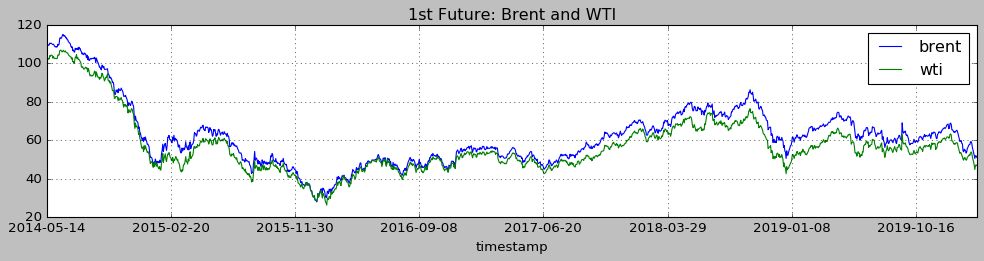

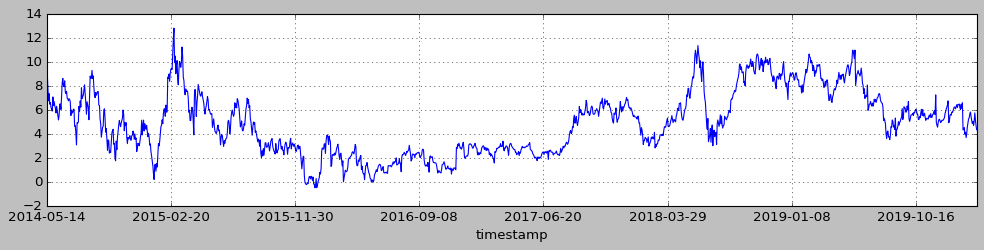

In [87]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sys
import matplotlib as mpl
from scipy.integrate import quad
from scipy.optimize import minimize
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau
Epsilon = sys.float_info.epsilon

mpl.rcParams["figure.figsize"] = (20, 3)
plt.style.use("classic")

# Data
path = "https://github.com/queiyanglim/trading_algorithm/blob/master/oil_trading/data/daily.csv?raw=true"
df_pull = pd.read_csv(path, header=[0,1], index_col = 0)

# Prepare data
brent = df_pull.brent.CLOSE
brent.name = "brent"
wti = df_pull.wti.CLOSE
wti.name = "wti"

df_raw= pd.concat([brent, wti], axis = 1)
df = df_raw.copy()
df = df.dropna()

df.head()
df.plot(figsize = (15, 3), grid = True, title = "1st Future: Brent and WTI")
plt.show()
df.head()
spread = df.brent - df.wti
spread.plot(figsize=(15,3), grid = True)

## Copula Spread Strategy

1. Clayton Copula
2. Gumbel Copula
3. Frank Copula

Source: [quantconnect](https://www.quantconnect.com/tutorials/strategy-library/pairs-trading-copula-vs-cointegration)

Kendall's tau: [Kendall's Tau](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient)

In [88]:
# Generate Return series
df_ret = np.log(df / df.shift(1)).dropna()
df_ret.head()

,brent,wti
timestamp,,
2014-05-15,0.002266,-0.008535
2014-05-16,-0.006267,0.005110
2014-05-19,-0.003468,0.005767
2014-05-20,0.002922,-0.002733
2014-05-21,0.007810,0.016861


In [0]:
# Kendall Tau and Theta Parameter Estimation
def estimate_parameter(copula_family, tau):
    if copula_family == "clayton":
        return 2 * tau / (1 - tau)
    elif copula_family == "gumbel":
        return 1 / (1 - tau)
    elif copula_family == "frank":
        # Debeye's 1st order function:
        integrand = lambda t: t / (np.exp(t) -1)
        frank_argmin = lambda theta: ((tau - 1)/4 - (quad(integrand, Epsilon, theta)[0]/theta - 1)/theta)**2 
        return float(minimize(frank_argmin, x0 = 4, method = "BFGS", tol = 1e-5).x)

# C(u,v;theta) Log-likelihood function
def copula_log_pdf(copula_family, theta, u, v):
    if  copula_family == 'clayton':
        pdf = (theta + 1) * ((u ** (-theta) + v ** (-theta) - 1) ** (-2 - 1 / theta)) * (u ** (-theta - 1) * v ** (-theta - 1))
    elif copula_family == 'frank':
        num = -theta * (np.exp(-theta) - 1) * (np.exp(-theta * (u + v)))
        denom = ((np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta) - 1)) ** 2
        pdf = num / denom        
    elif copula_family == 'gumbel':
        A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
        c = np.exp(-A ** (1 / theta))
        pdf = c * (u * v) ** (-1) * (A ** (-2 + 2 / theta)) * ((np.log(u) * np.log(v)) ** (theta - 1)) * (1 + (theta - 1) * A ** (-1 / theta))
        
        # TODO: issue when u = 1 and v = 1
        if math.isnan(A) or math.isnan(c) or math.isnan(pdf):
            print("error: ", "u: ", u, "v: ", v, "theta: ", theta, "\n")
            print("A:", A, "c:", c, "pdf:", pdf)
    return np.log(pdf)

Long spread: y - x if mispricing index, $MI_{y|x} < 0.05$ and $MI_{x|y} > 0.95$

Short spread: y - x if mispricing index, $MI_{y|x} > 0.05$ and $MI_{x|y} < 0.95$


In [0]:
def misprice_index(u, v, copula_family, theta):
    if copula_family == 'clayton':
        MI_u_v = v ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (-1 / theta - 1) # P(U<u|V=v)
        MI_v_u = u ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (-1 / theta - 1) # P(V<v|U=u)

    elif copula_family == 'frank':
        A = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta * v) - 1)
        B = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta * u) - 1)
        C = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta) - 1)
        MI_u_v = B / C
        MI_v_u = A / C
    
    elif copula_family == 'gumbel':
        A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
        C_uv = np.exp(-A ** (1 / theta))   # C_uv is gumbel copula function C(u,v)
        MI_u_v = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(v)) ** (theta - 1) * (1.0 / v)
        MI_v_u = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(u)) ** (theta - 1) * (1.0 / u)
    return MI_u_v, MI_v_u

In [91]:
# Confidence bands
# MAIN INPUT
top_band = 0.95
bottom_band = 1 - top_band
update_window = 250
signal = {}
long_short = 0

for i in range(update_window, len(df)+1):
    df_ret = df.iloc[:i].tail(update_window)
    df_ret = np.log(df_ret / df_ret.shift(1)).dropna()
    current_time = df_ret.index[-1]

    # y/v: brent, x/u: wti
    x = df_ret.wti
    y = df_ret.brent

    # New Signals:
    x_ret_new, y_ret_new =  x[-1], y[-1]

    # Convert return series of brent and wti into uniform values U and V using ECDF
    ecdf_x, ecdf_y = ECDF(x), ECDF(y)
    u, v = [ecdf_x(s) for s in x], [ecdf_y(s) for s in y]

    # Additional control to prevent feeding u=1.0 and v=1.0 which
    # results in invalid pdf
    zip_u_v = list(zip(u,v))
    if (1.0, 1.0) in zip_u_v:
        one_one_index = zip_u_v.index((1.0, 1.0))
        del zip_u_v[one_one_index]

    tau, tau_p_val = kendalltau(x,y)

    AIC_criteria = {}
    for fam in ["gumbel"]:
        param = estimate_parameter(fam, tau)
        lpdf = [ copula_log_pdf(fam, param, x, y) for x, y in zip_u_v]
        lpdf = np.nan_to_num(lpdf)
        log_likelihood = np.sum(lpdf)
        AIC_criteria[fam] = [param, -2 * log_likelihood + 2 * (1) ] # k = 1 for 1 parameter

    # Select the best copula based on the lowest AIC 
    best_copula = min(AIC_criteria.items(), key = lambda x: x[1][1])

    u_new = ecdf_x(x_ret_new)
    v_new = ecdf_y(y_ret_new)

    MI_u_v, MI_v_u = misprice_index(u_new, v_new, best_copula[0], best_copula[1][0])
    # M_v_u < 0.05 and M_u_v > 0.95, long spread
    # M_v_u > 0.95 and M_u_v < 0.05, short spread
    if (MI_u_v < bottom_band and MI_v_u > top_band):
        long_short = -1
    elif (MI_u_v > top_band and MI_v_u < bottom_band):
        long_short = 1
    # else:
    #     long_short = 0

    signal[current_time] = long_short

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


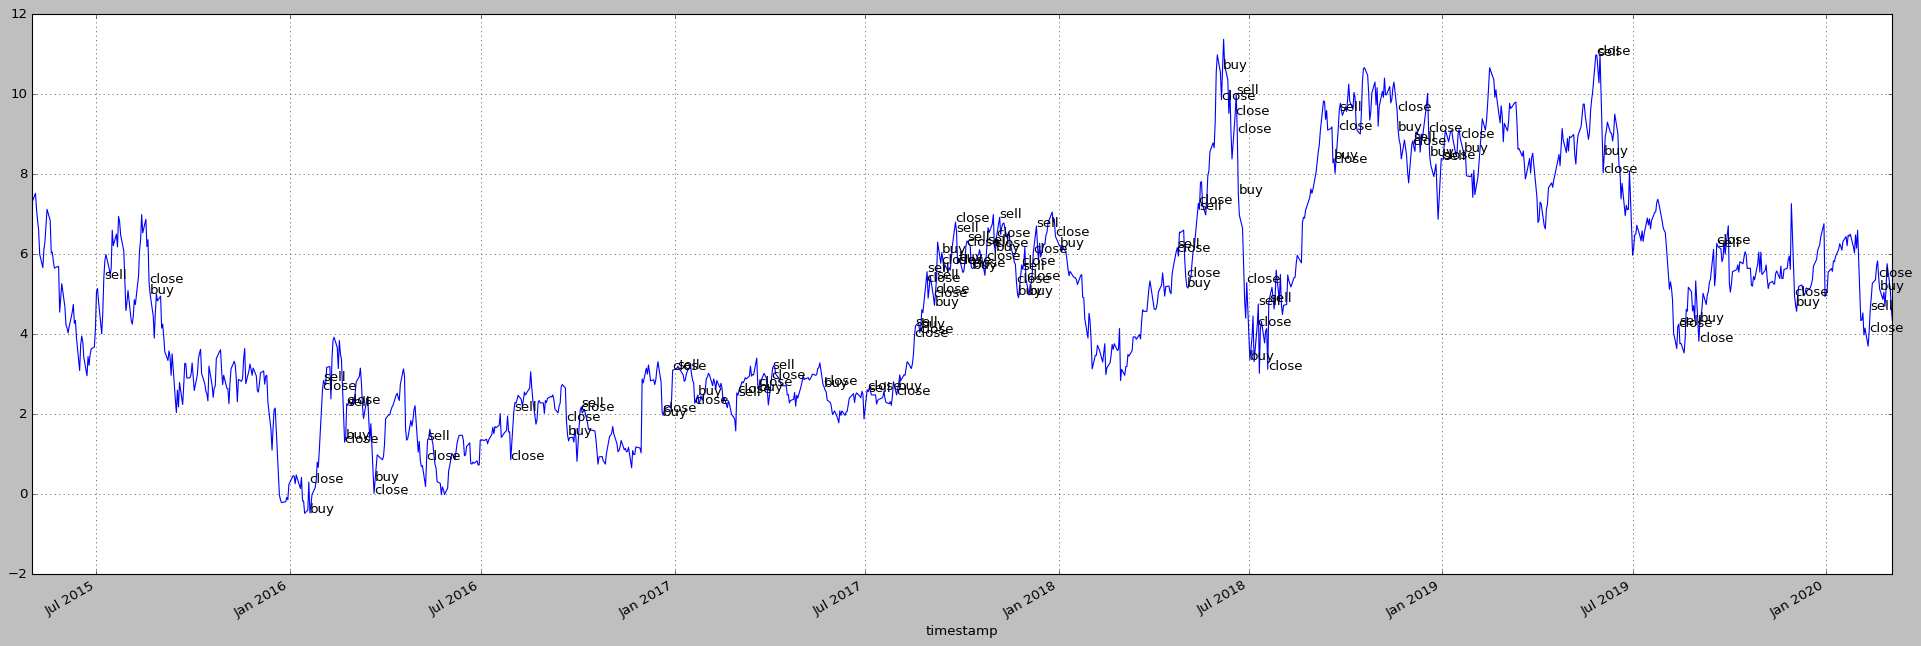

In [92]:
df["position"] = pd.DataFrame(signal,index=[0]).T
df_with_pos = df
df_with_pos["spread"] = df_with_pos.brent - df_with_pos.wti
df_with_pos = df_with_pos.dropna()

position = []
capital = 500000

def append_position_data(slice_data, brent_pos, wti_pos):
    global position
    position.append({"timestamp": data.name,
                    "brent_pos": brent_pos,
                    "wti_pos": wti_pos})

style = dict(size=15, color='gray')

df_with_pos.index = pd.to_datetime(df_with_pos.index, format="%Y-%m-%d")
ax = df_with_pos.spread.plot(figsize=(30,10), grid = True, plot = "Spread with buy/sell signals")

current_pos, brent_pos, wti_pos = 0, 0, 0
traded = []

for i, data in df_with_pos.iterrows():
    # Open position
    if current_pos == 0:
        # On long signal
        if data.position != 0:
            brent_pos = data.position * np.floor(capital/data.brent)
            wti_pos = - data.position * np.floor(capital/data.wti)
            current_pos = data.position
            open_price = data.spread
            if data.position == 1:
                ax.text(i, data.spread, "buy")
            elif data.position == -1:
                ax.text(i, data.spread, "sell")
    # When there is open position, decide if need to close
    elif current_pos != 0:
        # If current position is not equal to signal, close position
        if current_pos != data.position:
            close_price = data.spread
            traded.append(current_pos * (close_price - open_price))
            brent_pos, wti_pos, current_pos = 0, 0, 0
            ax.text(i, data.spread, "close")

    append_position_data(data, brent_pos, wti_pos)

df_pos = pd.DataFrame(position).set_index("timestamp")


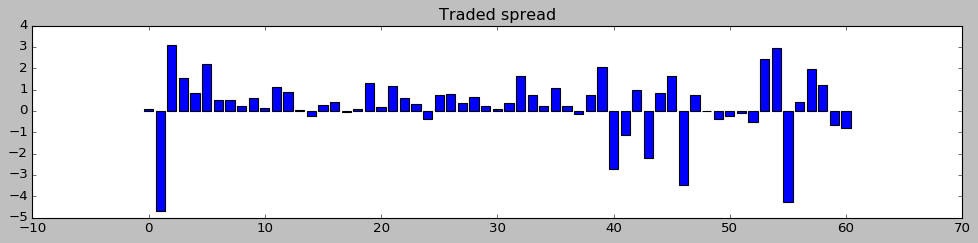

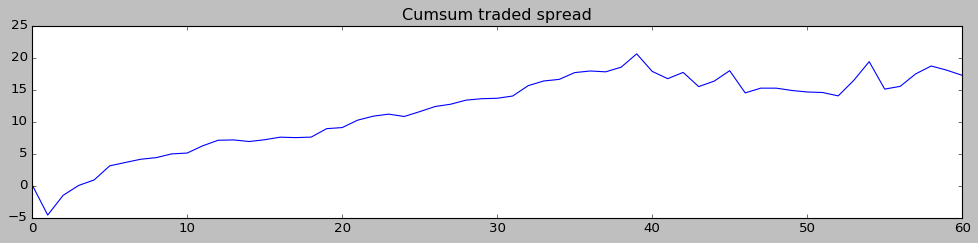

In [99]:
plt.rcParams["figure.figsize"] = [15,3]
plt.bar(range(len(traded)), traded)
plt.title("Traded spread")
plt.show()
plt.plot(np.cumsum(traded))
plt.title("Cumsum traded spread")
plt.show()